In [25]:
import os, sys

current_dir = os.getcwd()

target_folder = 'polygraphs'

target_path = current_dir[:current_dir.index(target_folder) + len(target_folder)]
sys.path.append(target_path)

In [1]:
from polygraphs.analysis import Processor
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
processor = Processor(["~/polygraphs-cache/results/"], config_check=False)
processor.add_config("reliability")
print(len(processor.graphs), len(processor.beliefs), len(processor.sims))
print(len(processor.beliefs.graphs[59]), len(processor.graphs[0].nodes), )

60 60 60
13032 13032


In [3]:
processor.graphs[0].pg['ndata']

{'logits': tensor([0.0040, 0.0040, 0.0040,  ..., 0.0040, 0.0040, 0.0040]), 'reliability': tensor([1., 1., 0.,  ..., 0., 0., 1.]), 'beliefs': tensor([0.2386, 0.5735, 0.8456,  ..., 0.2641, 0.6253, 0.0901])}

In [4]:
# picking a graph from the available graphs using indexing
graph = processor.graphs[0]

In [5]:
G = nx.read_gml("/Users/prudhvivuda/polygraphs-cache/francisbacon.gml", destringizer=int)
print(len(G))
print(G.nodes[8186])

13032
{'name': 'Sir Thomas Skipwith', 'original_id': 10011164}


## Applying Label Propagation

In [44]:
# Apply Label Propagation Algorithm
lp_communities = nx.algorithms.community.label_propagation_communities(graph)

# Convert generator output to dictionary: {node: community_id}
community_mapping = {}
for community_id, nodes in enumerate(lp_communities):
    for node in nodes:
        community_mapping[node] = community_id

In [45]:
# Convert community mapping to a DataFrame
lp_community_df = pd.DataFrame.from_dict(community_mapping, orient="index", columns=["lp_community_id"])
lp_community_df.reset_index(inplace=True)
lp_community_df.rename(columns={"index": "node"}, inplace=True)

lp_community_df.to_csv("label_propagation_community_assignments1.csv", index=False)

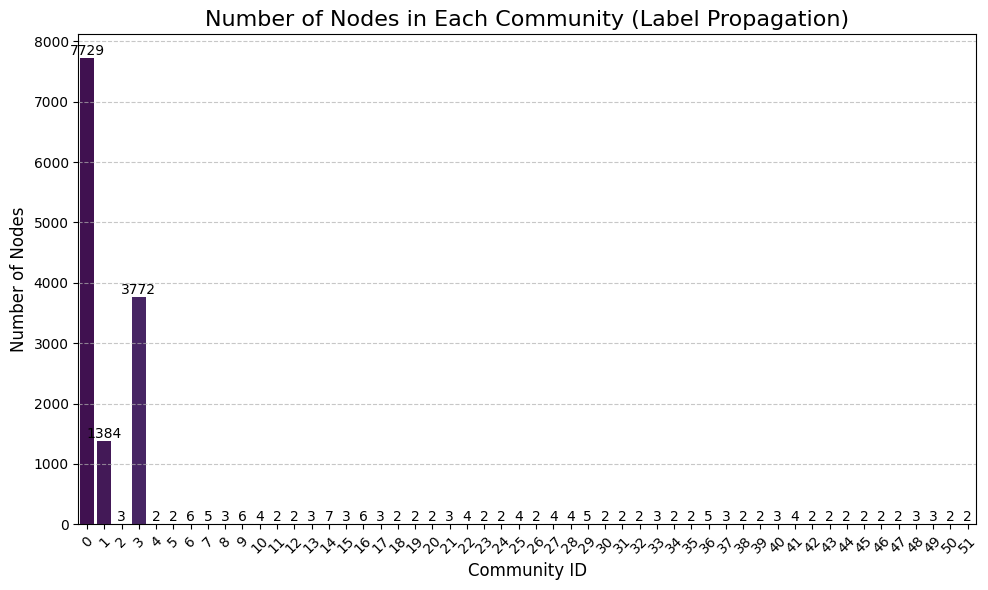

In [47]:
# Count the number of nodes in each community
community_sizes = lp_community_df["lp_community_id"].value_counts().sort_index()

# Plot a histogram of community sizes
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")

# Add counts on top of each bar
for bar, count in zip(barplot.patches, community_sizes.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Position the text
             str(count), ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Number of Nodes in Each Community (Label Propagation)", fontsize=16)
plt.xlabel("Community ID", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()

plt.show()


In [48]:
lp_community_df

,node,lp_community_id
0,0,0
1,1,0
2,2,0
3,3,0
4,5,0
...,...,...
13027,12917,49
13028,12984,50
13029,12950,50
13030,12968,51


In [53]:
lp_communities_df = lp_community_df[lp_community_df["lp_community_id"].isin([0,1,3])]
lp_communities_df

,node,lp_community_id
0,0,0
1,1,0
2,2,0
3,3,0
4,5,0
...,...,...
12883,8186,3
12884,8187,3
12885,8188,3
12886,8190,3


## Applying Louvain Propagation

In [33]:
import community as community_louvain
import random

random.seed(42)  # Set a fixed seed
louvain_communities = community_louvain.best_partition(graph, random_state=42)
louvain_community_mapping = louvain_communities  

print(set(louvain_communities.values()))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


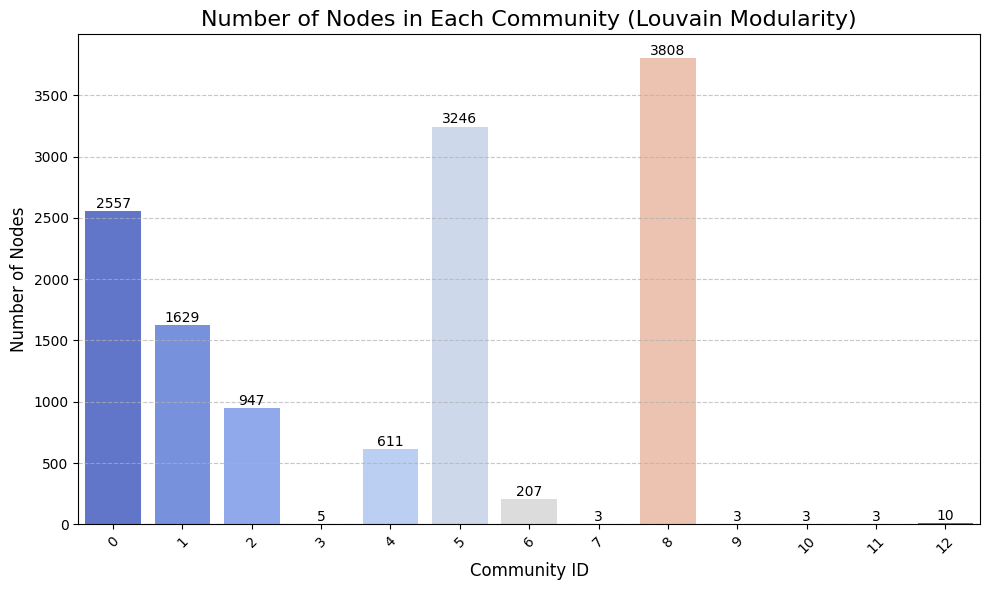

In [35]:
# Count the number of nodes in each Louvain community
louvain_community_sizes = pd.Series(louvain_community_mapping).value_counts().sort_index()

# Plot a histogram of Louvain community sizes
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=louvain_community_sizes.index, y=louvain_community_sizes.values, palette="coolwarm")

# Add counts on top of each bar
for bar, count in zip(barplot.patches, louvain_community_sizes.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Position the text
             str(count), ha='center', va='bottom', fontsize=10, color='black')

# Add titles and labels
plt.title("Number of Nodes in Each Community (Louvain Modularity)", fontsize=16)
plt.xlabel("Community ID", fontsize=12)
plt.ylabel("Number of Nodes", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()



plt.show()

In [43]:
selected_communities = {0, 1, 2, 4, 5, 6, 8}  # Communities to keep

filtered_communities = {node: comm for node, comm in louvain_communities.items() if comm in selected_communities}

louvain_communities_df = pd.DataFrame(list(filtered_communities.items()), columns=["node", "louvain_community_id"])

louvain_communities_df

,node,louvain_community_id
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
13000,13027,8
13001,13028,8
13002,13029,8
13003,13030,5


## Merging the communities and Mapping the communities with the groups

In [54]:
merged_df = lp_communities_df.merge(louvain_communities_df, on="node", how="inner")

merged_df.head()  # Display first few rows

,node,lp_community_id,louvain_community_id
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,5,0,0


In [ ]:
merged_df['groups'] = merged_df['node'].apply(lambda x: G.nodes[x].get('groups', []))

merged_df

,node,lp_community_id,louvain_community_id,groups
0,0,0,0,"[58, 128]"
1,1,0,0,[]
2,2,0,0,[]
3,3,0,0,"[90, 131]"
4,5,0,0,[]
...,...,...,...,...
12874,8186,3,4,[]
12875,8187,3,4,[130]
12876,8188,3,5,[130]
12877,8190,3,5,[]


In [57]:
# dropping groups which doesn't have any groups 
merged_df = merged_df[merged_df['groups'].apply(lambda x: len(x) > 0)]

merged_df

,node,lp_community_id,louvain_community_id,groups
0,0,0,0,"[58, 128]"
3,3,0,0,"[90, 131]"
9,11,0,1,[129]
10,12,0,2,"[8, 131]"
14,19,0,0,[131]
...,...,...,...,...
12871,8183,3,4,[130]
12872,8184,3,5,[130]
12875,8187,3,4,[130]
12876,8188,3,5,[130]


In [58]:
groups_df = pd.read_csv('/Users/prudhvivuda/Documents/SDFB_groups_2023_04_05.csv') 

# Create a dictionary mapping group ID to group name
entity_id_to_name = dict(zip(groups_df['id'], groups_df['name']))

# Function to map group IDs to group names
def map_group_names(entity_ids):
    return [entity_id_to_name.get(gid, "Unknown") for gid in entity_ids]

# Apply the mapping function to the 'groups' column
merged_df['group_name'] = merged_df['groups'].apply(map_group_names)

merged_df


/var/folders/1c/f0l1c8xj21b5_d53qldvsm200000gn/T/ipykernel_58390/4164211020.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['group_name'] = merged_df['groups'].apply(map_group_names)


,node,lp_community_id,louvain_community_id,groups,group_name
0,0,0,0,"[58, 128]","[Puritans, Scholars]"
3,3,0,0,"[90, 131]","[English Diplomats, Diplomats]"
9,11,0,1,[129],[Composers]
10,12,0,2,"[8, 131]","[Lords of the congregation, Diplomats]"
14,19,0,0,[131],[Diplomats]
...,...,...,...,...,...
12871,8183,3,4,[130],[Actors]
12872,8184,3,5,[130],[Actors]
12875,8187,3,4,[130],[Actors]
12876,8188,3,5,[130],[Actors]


## Collecting the Belief Data

In [13]:
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

In [14]:
beliefs

beliefs  sim                                          op  \
iteration node                                                               
0         0      0.238578    0  UnreliableNetworkModifiedAlignedBinomialOp   
          1      0.573534    0  UnreliableNetworkModifiedAlignedBinomialOp   
          2      0.845558    0  UnreliableNetworkModifiedAlignedBinomialOp   
          3      0.244649    0  UnreliableNetworkModifiedAlignedBinomialOp   
          4       0.26889    0  UnreliableNetworkModifiedAlignedBinomialOp   
...                   ...  ...                                         ...   
25000     13027  0.999995   59                    UnreliableNetworkIdealOp   
          13028  0.999995   59                    UnreliableNetworkIdealOp   
          13029  0.999986   59                    UnreliableNetworkIdealOp   
          13030  0.469774   59                    UnreliableNetworkIdealOp   
          13031  0.999971   59                    UnreliableNetworkIdealOp   

                 reliability  
iteration node                
0         0             0.75  
          1             0.75  
          2             0.75  
          3             0.75  
          4             0.75  
...                      ...  
25000     13027         0.75  
          13028         0.75  
          13029         0.75  
          13030         0.75  
          13031         0.75  

[197043840 rows x 4 columns]

In [15]:
blfs = beliefs.reset_index()

In [16]:
blfs

,iteration,node,beliefs,sim,op,reliability
0,0,0,0.238578,0,UnreliableNetworkModifiedAlignedBinomialOp,0.75
1,0,1,0.573534,0,UnreliableNetworkModifiedAlignedBinomialOp,0.75
2,0,2,0.845558,0,UnreliableNetworkModifiedAlignedBinomialOp,0.75
3,0,3,0.244649,0,UnreliableNetworkModifiedAlignedBinomialOp,0.75
4,0,4,0.26889,0,UnreliableNetworkModifiedAlignedBinomialOp,0.75
...,...,...,...,...,...,...
197043835,25000,13027,0.999995,59,UnreliableNetworkIdealOp,0.75
197043836,25000,13028,0.999995,59,UnreliableNetworkIdealOp,0.75
197043837,25000,13029,0.999986,59,UnreliableNetworkIdealOp,0.75
197043838,25000,13030,0.469774,59,UnreliableNetworkIdealOp,0.75


## Extracting belief for a given group of nodes

In [17]:
def compute_group_belief_stats(beliefs, labelled_communities_df, group_number):
    """
    Extracts beliefs for a given group number and computes:
    - Mean of group means
    - Median of group medians
    - Both per simulation (sim by sim) and across simulations (aggregated by 'op').

    Parameters:
    - beliefs (pd.DataFrame): DataFrame containing belief data with 'sim' and 'op'.
    - labelled_communities_df (pd.DataFrame): DataFrame mapping nodes to groups and communities.
    - group_number (int): The group number to filter beliefs by.

    Returns:
    - results (dict): Dictionary with mean and median statistics.
    """
    
    # Get nodes belonging to the given group number
    nodes_in_group = labelled_communities_df[labelled_communities_df['groups'].apply(lambda x: group_number in x)]['node'].tolist()

    # Filter beliefs for selected nodes
    group_beliefs = beliefs[beliefs['node'].isin(nodes_in_group)]
    
    # Compute stats per simulation
    sim_stats = group_beliefs.groupby(["sim", "op"])['beliefs'].agg(['mean', 'median', 'std', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]).reset_index()
    sim_stats.columns = ['sim', 'op', 'mean', 'median', 'std', 'min', 'max', 'quantile_25', 'quantile_75']

    # Compute mean of means and median of medians across simulations
    aggregated_stats = sim_stats.groupby("op").agg(
            mean=('mean', 'mean'),
            median=('median', 'median'),
            std=('std', 'mean'),
            min=('min', 'mean'),
            max=('max', 'mean'),
            quantile_25=('quantile_25', 'mean'),
            quantile_75=('quantile_75', 'mean')
        ).reset_index()

    # Return results as a dictionary
    return {
        'sim_stats': sim_stats,          # Sim-by-sim statistics
        'aggregated_stats': aggregated_stats  # Aggregated across sims
    }

# Example usage:
results = compute_group_belief_stats(blfs, labelled_communities_df, group_number=65)
sim_by_sim_stats = results['sim_stats']
aggregated_stats = results['aggregated_stats']


In [18]:
sim_by_sim_stats

,sim,op,mean,median,std,min,max,quantile_25,quantile_75
0,0,UnreliableNetworkModifiedAlignedBinomialOp,0.919376,0.999999,0.214867,0.004969,1.0,0.999554,1.0
1,1,UnreliableNetworkModifiedAlignedBinomialOp,0.965092,1.0,0.130778,0.014403,1.0,0.999988,1.0
2,2,UnreliableNetworkModifiedAlignedBinomialOp,0.945934,1.0,0.184653,0.001427,1.0,0.999963,1.0
3,3,UnreliableNetworkModifiedAlignedBinomialOp,0.952967,1.0,0.161015,0.010804,1.0,0.999993,1.0
4,4,UnreliableNetworkModifiedAlignedBinomialOp,0.948263,1.0,0.186235,0.000481,1.0,0.999965,1.0
5,5,UnreliableNetworkIdealOp,0.947813,1.0,0.184557,0.000644,1.0,0.999999,1.0
6,6,UnreliableNetworkIdealOp,0.925912,1.0,0.227774,0.000089,1.0,0.999999,1.0
7,7,UnreliableNetworkIdealOp,0.948723,1.0,0.159716,0.001597,1.0,0.999997,1.0
8,8,UnreliableNetworkIdealOp,0.951336,1.0,0.179306,0.00354,1.0,0.999999,1.0
9,9,UnreliableNetworkIdealOp,0.937884,1.0,0.216655,0.000204,1.0,0.999999,1.0


In [19]:
aggregated_stats

,op,mean,median,std,min,max,quantile_25,quantile_75
0,BalaGoyalOp,0.963669,1.0,0.140927,0.015667,1.0,1.0,1.0
1,UnreliableNetworkBasicGullibleBinomialOp,0.938281,1.0,0.194541,0.00045,1.0,0.99999,1.0
2,UnreliableNetworkBasicGullibleNegativeEpsOp,0.903961,1.0,0.25446,0.000674,1.0,0.997846,1.0
3,UnreliableNetworkIdealOp,0.946795,1.0,0.180336,0.002644,1.0,0.999998,1.0
4,UnreliableNetworkModifiedAlignedBinomialOp,0.944053,1.0,0.180301,0.005499,1.0,0.999911,1.0
5,UnreliableNetworkModifiedAlignedNegativeEpsOp,0.876823,0.999995,0.263607,0.001953,1.0,0.928619,1.0


## Credence over sims

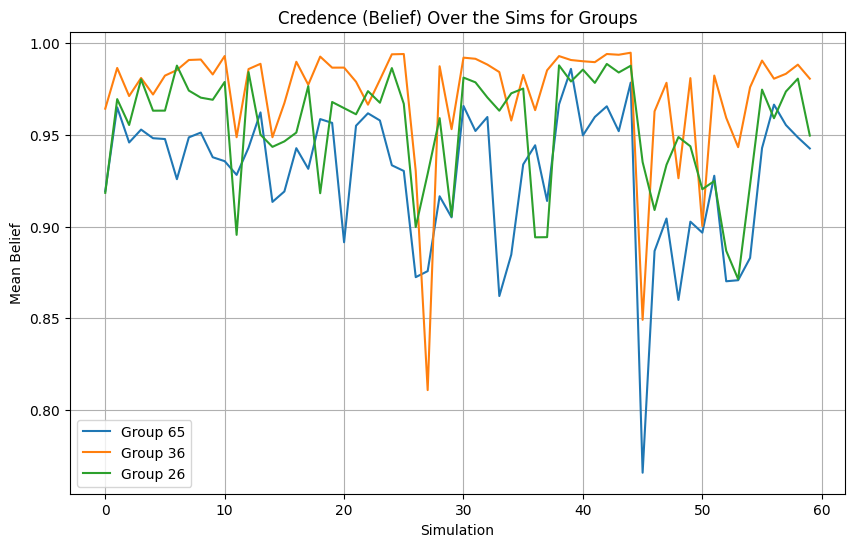

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_credence_over_time(beliefs, labelled_communities_df, group_numbers):
    """
    Plots the credence (belief) over time for the specified group numbers.

    Parameters:
    - beliefs (pd.DataFrame): DataFrame containing belief data with 'sim' and 'op'.
    - labelled_communities_df (pd.DataFrame): DataFrame mapping nodes to groups and communities.
    - group_numbers (list of int): The group numbers to filter and plot.
    """
    plt.figure(figsize=(10, 6))

    for group_number in group_numbers:
        # Get nodes belonging to the given group number
        nodes_in_group = labelled_communities_df[
            labelled_communities_df['groups'].apply(lambda x: group_number in x)
        ]['node'].tolist()

        # Filter beliefs for selected nodes
        group_beliefs = beliefs[beliefs['node'].isin(nodes_in_group)]

        # Compute mean belief for each simulation
        group_beliefs_mean = group_beliefs.groupby(['sim'])['beliefs'].mean()

        # Plot the mean belief over time
        plt.plot(group_beliefs_mean.index, group_beliefs_mean.values, label=f'Group {group_number}')

    # Customize the plot
    plt.title('Credence (Belief) Over the Sims for Groups')
    plt.xlabel('Simulation')
    plt.ylabel('Mean Belief')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage:
royal_society = 65
royal_society_founding_members = 36
cavalier_poets = 26
plot_credence_over_time(blfs, labelled_communities_df, group_numbers=[royal_society, royal_society_founding_members, cavalier_poets])


In [21]:
group_numbers = [65]

for group_number in group_numbers:
    # Get nodes belonging to the given group number
    nodes_in_group = labelled_communities_df[
        labelled_communities_df['groups'].apply(lambda x: group_number in x)
    ]['node'].tolist()

    # Filter beliefs for selected nodes
    group_beliefs = blfs[blfs['node'].isin(nodes_in_group)]
    
    aggregated_beliefs = (
        group_beliefs.groupby(["op", "iteration"])
        .agg(
            mean_beliefs=("beliefs", "mean"),
            median_beliefs=("beliefs", "median"),
            std_beliefs=("beliefs", "std"),
            min_beliefs=("beliefs", "min"),
            max_beliefs=("beliefs", "max"),
            p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
            p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
        )
        .reset_index()
    )

In [22]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs
0,BalaGoyalOp,0,0.491422,0.478394,0.298836,0.000108,0.997765,0.21711,0.766967
1,BalaGoyalOp,1,0.49348,0.485763,0.299092,0.000121,0.997618,0.220624,0.767328
2,BalaGoyalOp,100,0.621161,0.685547,0.311215,0.000178,0.999892,0.360945,0.912326
3,BalaGoyalOp,200,0.701036,0.813842,0.306421,0.0003,1.0,0.474975,0.972499
4,BalaGoyalOp,300,0.761647,0.911322,0.297517,0.001928,1.0,0.591491,0.993756
...,...,...,...,...,...,...,...,...,...
1507,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.92095,1.0,0.236453,0.0,1.0,0.999946,1.0
1508,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.920477,1.0,0.238282,0.0,1.0,0.999958,1.0
1509,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.920515,1.0,0.237192,0.0,1.0,0.999954,1.0
1510,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.921039,1.0,0.23551,0.0,1.0,0.999965,1.0


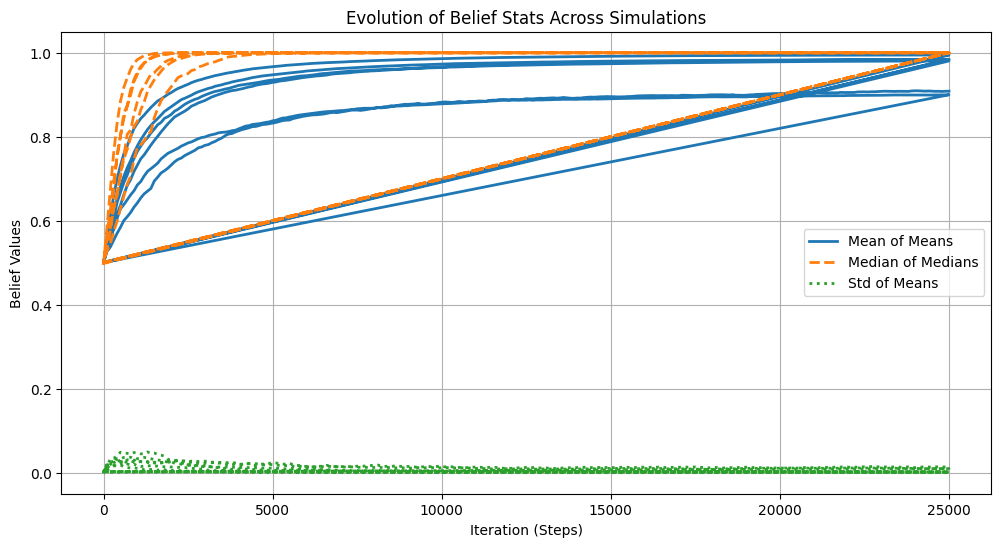

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sim_by_sim_stats(beliefs):
    """
    Plots mean of means, median of medians, and std of means per simulation, 
    averaged across simulations to track belief evolution.

    Parameters:
    - beliefs (pd.DataFrame): DataFrame containing columns ['op', 'sim', 'iteration', 'beliefs'].
    """
    # Compute mean, median, and std of beliefs for each (sim, iteration), grouped by operator
    sim_iteration_stats = (
        beliefs.groupby(["op", "sim", "iteration"])["beliefs"]
        .agg(mean_beliefs="mean", median_beliefs="median", std_beliefs="std")
        .reset_index()
    )

    # Average across simulations to get aggregate trends
    avg_stats_by_iteration = (
        sim_iteration_stats.groupby(["op", "iteration"])
        .agg(mean_of_means=("mean_beliefs", "mean"),
             median_of_medians=("median_beliefs", "median"),
             std_of_means=("mean_beliefs", "std"))
        .reset_index()
    )

    plt.figure(figsize=(12, 6))

    # Plot trends for Mean of Means, Median of Medians, and Std of Means
    plt.plot(avg_stats_by_iteration["iteration"], avg_stats_by_iteration["mean_of_means"], label="Mean of Means", lw=2)
    plt.plot(avg_stats_by_iteration["iteration"], avg_stats_by_iteration["median_of_medians"], linestyle="dashed", label="Median of Medians", lw=2)
    plt.plot(avg_stats_by_iteration["iteration"], avg_stats_by_iteration["std_of_means"], linestyle="dotted", label="Std of Means", lw=2)

    plt.title("Evolution of Belief Stats Across Simulations")
    plt.xlabel("Iteration (Steps)")
    plt.ylabel("Belief Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the function
plot_sim_by_sim_stats(beliefs)


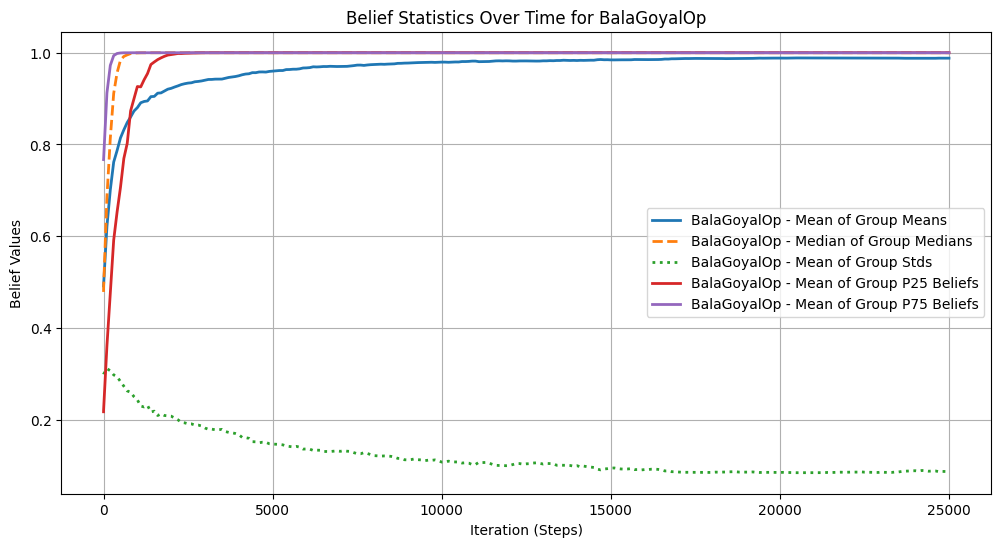

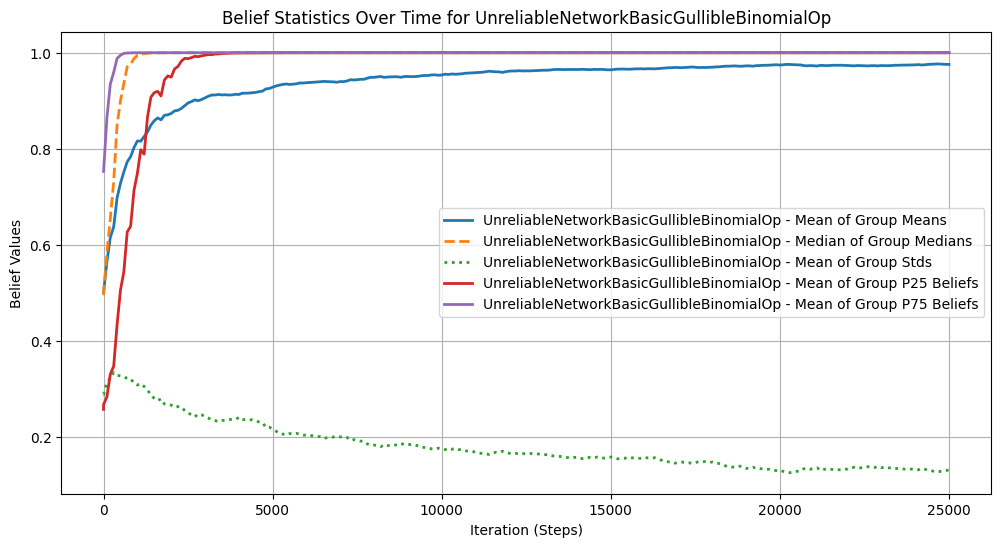

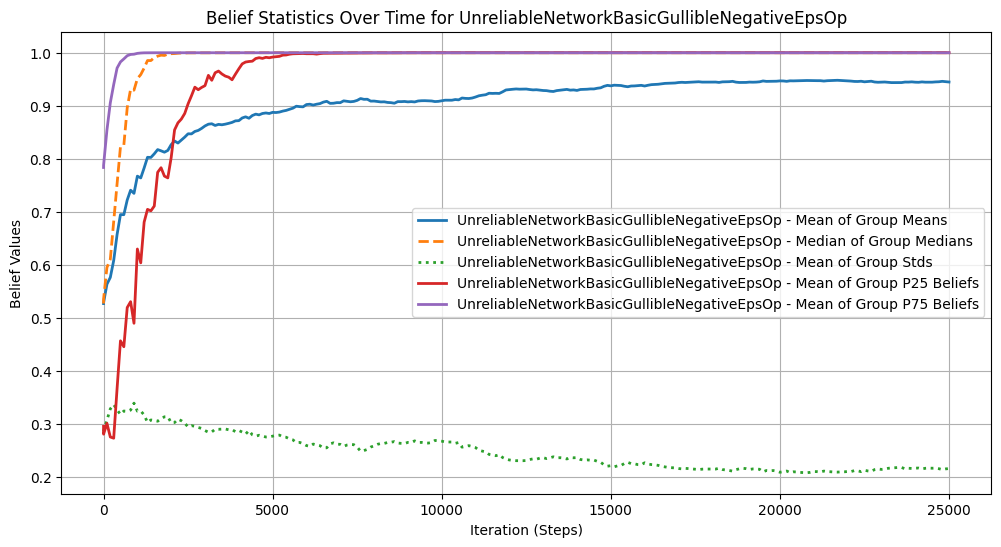

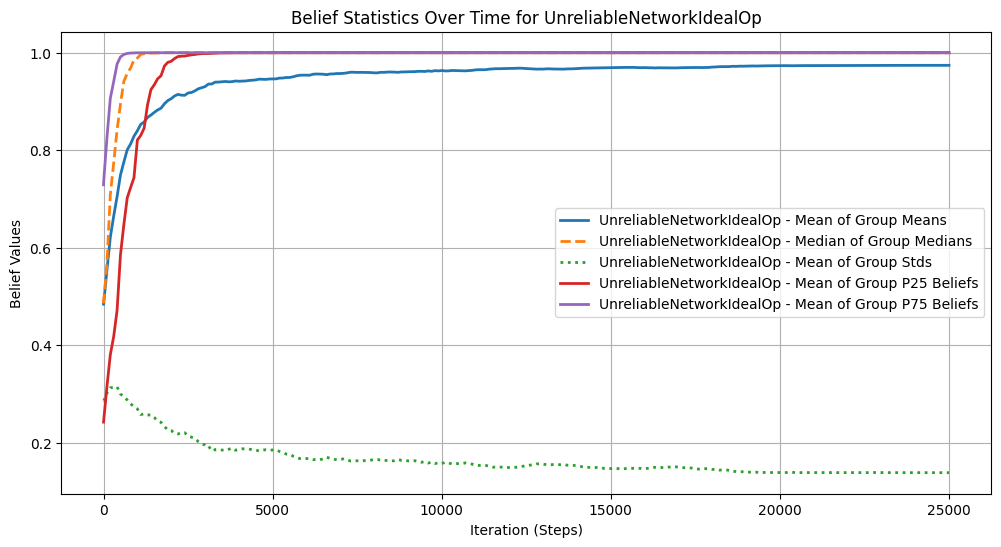

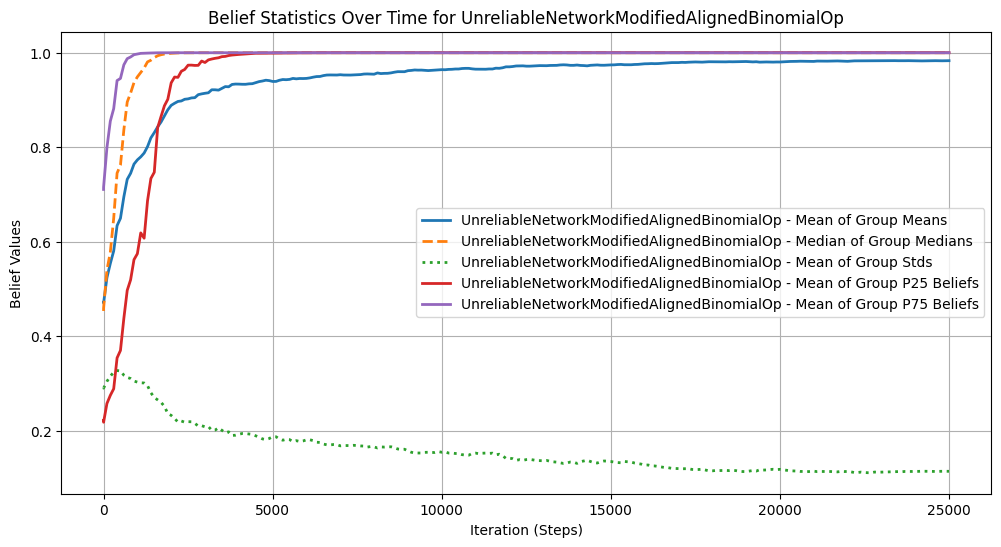

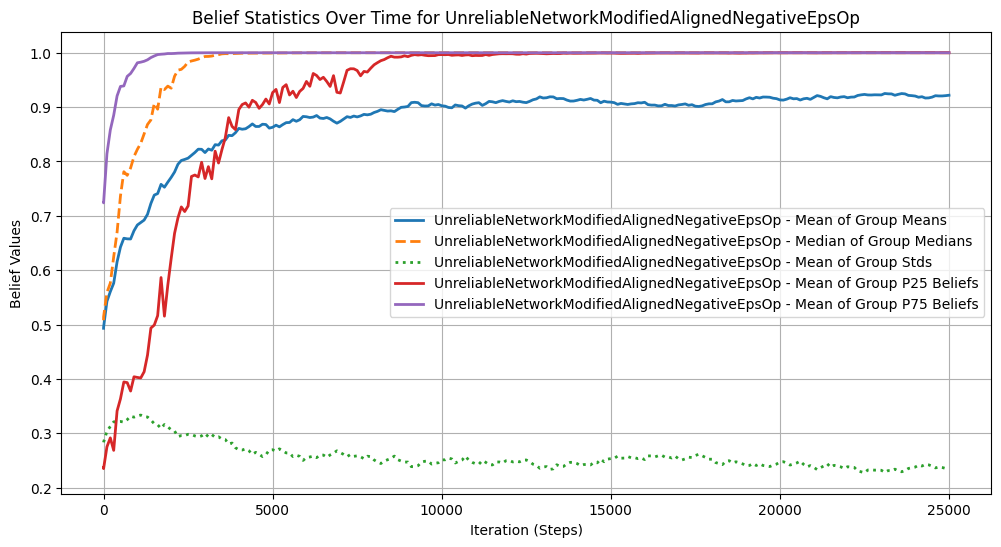

In [24]:
import matplotlib.pyplot as plt

def plot_group_stats(aggregated_beliefs, op):
    """
    Plots different belief statistics (mean, median, std, min, max, p25, p75) across iterations for a given op.

    Parameters:
    - aggregated_beliefs (pd.DataFrame): DataFrame with belief statistics.
    - op (str): The operation (Op) for which stats should be plotted.
    """

    op_beliefs = aggregated_beliefs[aggregated_beliefs['op'] == op]

    # Compute stats across iterations
    mean_of_group_means = op_beliefs.groupby('iteration')['mean_beliefs'].mean()
    median_of_group_medians = op_beliefs.groupby('iteration')['median_beliefs'].median()
    mean_of_group_stds = op_beliefs.groupby('iteration')['std_beliefs'].mean()
    # mean_of_group_min = op_beliefs.groupby('iteration')['min_beliefs'].mean()
    # mean_of_group_max = op_beliefs.groupby('iteration')['max_beliefs'].mean()
    mean_of_group_p25 = op_beliefs.groupby('iteration')['p25_beliefs'].mean()
    mean_of_group_p75 = op_beliefs.groupby('iteration')['p75_beliefs'].mean()

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(mean_of_group_means.index, mean_of_group_means, label=f'{op} - Mean of Group Means', lw=2)
    plt.plot(median_of_group_medians.index, median_of_group_medians, linestyle='dashed', label=f'{op} - Median of Group Medians', lw=2)
    plt.plot(mean_of_group_stds.index, mean_of_group_stds, linestyle='dotted', label=f'{op} - Mean of Group Stds', lw=2)
    # plt.plot(mean_of_group_min.index, mean_of_group_min, linestyle='dashdot', label=f'{op} - Mean of Group Min Beliefs', lw=2)
    # plt.plot(mean_of_group_max.index, mean_of_group_max, linestyle='dotted', label=f'{op} - Mean of Group Max Beliefs', lw=2)
    plt.plot(mean_of_group_p25.index, mean_of_group_p25, linestyle='solid', label=f'{op} - Mean of Group P25 Beliefs', lw=2)
    plt.plot(mean_of_group_p75.index, mean_of_group_p75, linestyle='solid', label=f'{op} - Mean of Group P75 Beliefs', lw=2)

    plt.title(f"Belief Statistics Over Time for {op}")
    plt.xlabel("Iteration (Steps)")
    plt.ylabel("Belief Values")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the function for each operation in the dataset
unique_ops = aggregated_beliefs["op"].unique()

for op in unique_ops:
    plot_group_stats(aggregated_beliefs, op)
